In [1]:
import pandas as pd
import networkx as nx

In [2]:
from iac_sketch import data, etl, sketch, transform, system_tests

In [3]:
# DEBUG
import importlib

importlib.reload(data)
importlib.reload(etl)
importlib.reload(sketch)
importlib.reload(transform)
importlib.reload(system_tests)
# architect = sketch.Architect("../public/components")
# registry = architect.parse()

<module 'iac_sketch.system_tests' from '/Users/zhafen/repos/iac-sketch/iac_sketch/system_tests.py'>

In [4]:
architect = sketch.Architect()
registry = architect.perform_registry_etl()
tests, test_results = architect.validate_registry()
tests

,test.comp_ind,test.value,code.value,errors,test_passed
entity,,,,,
test_executes_tests,1,<NA>,NaN,<NA>,<NA>
test_fully_connected,1,<NA>,iac_sketch.system_tests.test_connected,,False
test_fully_defined,1,<NA>,iac_sketch.system_tests.test_defined,,False
test_fully_designed,1,<NA>,iac_sketch.system_tests.test_designed,,False
test_fully_implemented,1,<NA>,iac_sketch.system_tests.test_implemented,,False
test_perform_registry_etl,1,<NA>,NaN,<NA>,<NA>


In [5]:
with pd.option_context('display.max_colwidth', None):
    print(tests.query("errors.notna() and errors != ''")["errors"])

Series([], Name: errors, dtype: object)


In [6]:
# Show results
for test_key, test_result in test_results.items():
    print(f"{test_key}:")
    display(test_result)
    print("")

test_fully_connected:


,connected_component_group,comp_ind
entity,,
alternative_to,9,6
apply_postprocess_transforms,3,0
apply_preprocess_transforms,3,6
apply_system_transforms,3,3
apply_transform,1,2
apply_transforms,10,4
can_document_workflows,11,3
can_execute_tests,2,3
can_perform_registry_etl,4,3



test_fully_defined:


,comp_ind,multiplicity,unparsed_fields,is_defined,fields,is_valid,errors
entity,,,,,,,
subtask,0,0..*,{},False,"{'entity': <Schema Field(name=entity, type=Dat...",False,Component definition does not exist.
subtask_of,0,0..*,{},False,"{'entity': <Schema Field(name=entity, type=Dat...",False,Component definition does not exist.



test_fully_designed:


,entity,comp_ind,value,link_type,source,target
0,can_document_workflows,1,iac_sketch_infrastructure,NaN,NaN,NaN
9,minimal_workflow_orchestration_functionality,1,iac_sketch_infrastructure,NaN,NaN,NaN
10,minimizes_structure_repetition,1,iac_sketch_infrastructure,NaN,NaN,NaN



test_fully_implemented:


,entity,comp_ind,value,link.link_type,link.source,link.target,status.comp_ind,status.value
0,can_document_workflows,1,iac_sketch_infrastructure,NaN,NaN,NaN,NaN,NaN
1,can_execute_tests,1,iac_sketch_infrastructure,satisfies,executes_tests,can_execute_tests,NaN,NaN
2,can_execute_tests,1,iac_sketch_infrastructure,satisfies,test_executes_tests,can_execute_tests,NaN,NaN
3,can_perform_registry_etl,1,iac_sketch_infrastructure,satisfies,perform_registry_etl,can_perform_registry_etl,NaN,NaN
4,can_perform_registry_etl,1,iac_sketch_infrastructure,satisfies,test_perform_registry_etl,can_perform_registry_etl,NaN,NaN
5,fully_connected,1,NaN,satisfies,test_fully_connected,fully_connected,4.0,in development
6,fully_defined,1,NaN,satisfies,test_fully_defined,fully_defined,4.0,in development
7,fully_designed,1,NaN,satisfies,test_fully_designed,fully_designed,4.0,in development
8,fully_implemented,1,NaN,satisfies,test_fully_implemented,fully_implemented,4.0,in development
9,minimal_workflow_orchestration_functionality,1,iac_sketch_infrastructure,NaN,NaN,NaN,NaN,NaN


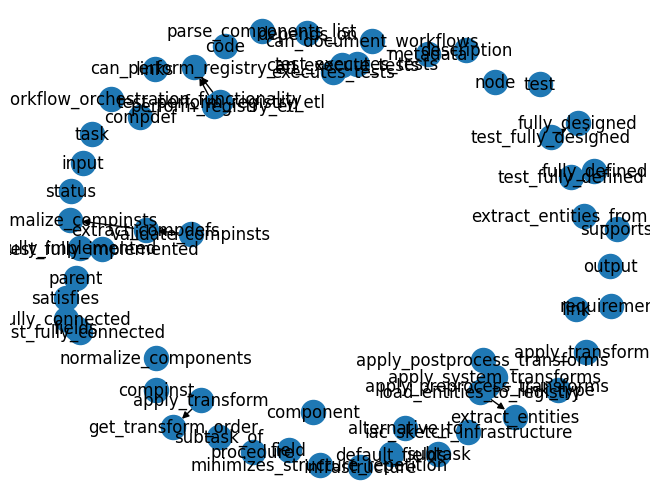

In [7]:
# Visualize the graph
nx.draw(registry.graph, with_labels=True)

In [8]:
import ast

In [9]:
with open("../iac_sketch/etl.py", "r") as f:
    source = f.read()
tree = ast.parse(source)
tree

In [71]:
class ComponentVisitor(ast.NodeVisitor):

    def __init__(self):
        self.path = []
        self.components = []
        self.comp_count = 0

    def generic_visit(self, node):

        entity, comp_key = self.get_node_id(node)

        # Create a component
        comp = {}
        self.comp_count = 0
        for field_key, field_value in ast.iter_fields(tree):
            comp[field_key] = self.parse_field(field_value)

        component = {
            "entity": entity,
            "comp_key": comp_key,
            "component_type": node.__class__.__name__,
            "component": comp,
        }
        self.components.append(component)

        self.path.append(comp_key)
        super().generic_visit(node)

        self.path.pop()

    def get_node_id(self, node):

        # Get the path
        if "name" in node._fields:
            comp_key = node.name
        else:
            comp_key = str(self.comp_count)
            self.comp_count += 1

        entity = ".".join(self.path)

        return entity, comp_key

    def get_node_path(self, node):

        entity, comp_key = self.get_node_id(node)
        return f"{entity}.{comp_key}"

    def parse_field(self, field_value):

        if isinstance(field_value, list):
            return [self.parse_field(item) for item in field_value]
        elif isinstance(field_value, dict):
            return {key: self.parse_field(value) for key, value in field_value.items()}
        elif isinstance(field_value, ast.Constant):
            return field_value.value
        elif isinstance(field_value, ast.AST):
            return self.get_node_path(field_value)
        else:
            raise ValueError(f"Unsupported field type: {type(field_value)}")

In [72]:
visitor = ComponentVisitor()

In [73]:
visitor.visit(tree)

In [75]:
pd.DataFrame(visitor.components)

,entity,comp_key,component_type,component
0,,0,Module,"{'body': ['.0', '.1', '.2', '.3', '.4', '.5', ..."
1,0,11,Expr,"{'body': ['0.0', '0.1', '0.2', '0.3', '0.4', '..."
2,0.11,11,Constant,"{'body': ['0.11.0', '0.11.1', '0.11.2', '0.11...."
3,0,11,Import,"{'body': ['0.0', '0.1', '0.2', '0.3', '0.4', '..."
4,0.11,copy,alias,"{'body': ['0.11.0', '0.11.1', '0.11.2', '0.11...."
...,...,...,...,...
1171,0.TransformSystem.apply_postprocess_transforms...,11,Load,{'body': ['0.TransformSystem.apply_postprocess...
1172,0.TransformSystem.apply_postprocess_transforms,11,Attribute,{'body': ['0.TransformSystem.apply_postprocess...
1173,0.TransformSystem.apply_postprocess_transforms.11,11,Name,{'body': ['0.TransformSystem.apply_postprocess...
1174,0.TransformSystem.apply_postprocess_transforms...,11,Load,{'body': ['0.TransformSystem.apply_postprocess...


In [ ]:
type(tree.body[-1])

In [ ]:
dict(ast.iter_fields(child_node))

In [ ]:
components = []
for child_node in ast.iter_child_nodes(tree.body[-1]):
    comp_i = {
        "component_type": type(child_node).__name__
    }
    components.append(comp_i)

components

In [ ]:
tree.body[-1].__dir__()

In [ ]:
for item in ast.iter_fields(tree.body[-1].body[-1]):
    print(item)

In [ ]:
visitor.visit(tree.body[-1])

In [ ]:
ast.walk(visitor.visit(tree))

In [ ]:
for item in ast.walk(tree):
    print(item)

In [ ]:
visitor.visit_Constant(tree)

In [ ]:
components = {}
for field, value in ast.iter_fields(tree):
    print(field, value)
    if isinstance(value, str)

In [ ]:
for item in ast.iter_child_nodes(transform_sys_tree):
    print(item)

In [ ]:
ast.get_source_segment(source, transform_sys_tree)

In [ ]:
ast.get_docstring(transform_sys_tree)

In [ ]:
isinstance(transform_sys_tree, ast.AST)